In [15]:
"""
explain how to use kenkenpa with the example of React-Agent.
https://langchain-ai.github.io/langgraph/
"""

'\nexplain how to use kenkenpa with the example of React-Agent.\nhttps://langchain-ai.github.io/langgraph/\n'

In [16]:
# Define the Tool node as usual.
from langchain_core.tools import tool

@tool
def search(query: str):
    """Call to surf the web."""

    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 60 degrees and foggy."
    return "It's 90 degrees and sunny."

In [17]:
# Define the factory function for the Tool node.
from langgraph.prebuilt import ToolNode

tools = {
    "search_function":search,
    }

def gen_tool_node(factory_parameter,flow_parameter):
    functions = factory_parameter['functions']

    tool_functions = []
    for function in functions:
        tool_functions.append(tools[function])

    tool_node = ToolNode(tool_functions)
    return tool_node

In [18]:
# Define the factory function for the agent node.
from langchain_openai import ChatOpenAI

def gen_agent(factory_parameter,flow_parameter):
    functions = factory_parameter['functions']

    tool_functions = []
    for function in functions:
        tool_functions.append(tools[function])

     # Setting up the LLM
    model = ChatOpenAI(
        model="gpt-4o-mini"
    )

    model = model.bind_tools(tool_functions)

    # Define the function that calls the model
    def call_model(state):
        messages = state['messages']
        response = model.invoke(messages)
        # We return a list, because this will get added to the existing list
        return {"messages": [response]}

    return call_model

In [19]:
# Define a function to evaluate whether the last message is a tool call instead of should_continue.
def is_tool_message(state, config, **kwargs):
    """Evaluate whether the last message is a tool call."""
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return True
    return False

In [20]:
# Create structured data representing a StateGraph.
graph_settings = {
    "graph_type":"stategraph",
    "flow_parameter":{
        "name":"React-Agent",
        "state" : [
            {
                "field_name": "messages", # state name
                "type": "list", # type(*1)
                "reducer":"add_messages" # reducer(*2)
            },
        ],
    },
    "flows":[
        { # agent node(*3)
            "graph_type":"node",
            "flow_parameter":{
                "name":"agent",
                "factory":"agent_node_factory",
            },
            "factory_parameter" : {
                "functions":[
                    "search_function",
                ],
            },
        },
        { # tools node(*3)
            "graph_type":"node",
            "flow_parameter":{
                "name":"tools",
                "factory":"tool_node_factory",
            },
            "factory_parameter":{
                "functions":[
                    "search_function",
                ],
            },
        },
        {# edge START -> agent
            "graph_type":"edge",
            "flow_parameter":{
                "start_key":"START",
                "end_key":"agent"
            },
        },
        {# coditional edge 
            "graph_type":"configurable_conditional_edge",
            "flow_parameter":{
                "start_key":"agent",
                "conditions":[
                    {
                        # Transition to the tools node if the result of is_tool_message is True.
                        "expression": {
                            "eq": [{"type": "function", "name": "is_tool_message_function"}, True], # *4
                        },
                        "result": "tools"
                    },
                    {"default": "END"} 
                ]
            },
        },
        {# edge tools -> agent
            "graph_type":"edge",
            "flow_parameter":{
                "start_key":"tools",
                "end_key":"agent"
            },
        },
    ]
}

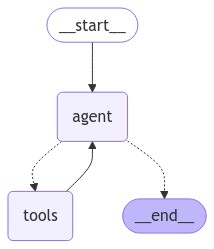

The current weather in San Francisco is 60 degrees and foggy.


In [21]:
# Generate a StateGraphBuilder from graph_settings.
from langchain_core.messages import HumanMessage
from langgraph.graph import  add_messages
from langgraph.checkpoint.memory import MemorySaver

from kenkenpa.builder import StateGraphBuilder

# Instantiate the StateGraphBuilder
stategraph_builder = StateGraphBuilder(graph_settings)

# Some preparations are needed to generate a compilable StateGraph.
# *1. Register the types to be used. (list is reserved, but it is written for explanation purposes.)
#stategraph_builder.add_type("list", list)

# *2. Register the reducers to be used.
stategraph_builder.add_reducer("add_messages",add_messages)

# *3. Register the Node Factories.
stategraph_builder.add_node_factory("agent_node_factory",gen_agent)
stategraph_builder.add_node_factory("tool_node_factory",gen_tool_node)

# *4. Register the evaluation functions as well.
stategraph_builder.add_evaluete_function("is_tool_message_function", is_tool_message,)

# You can obtain a compilable StateGraph with the gen_stategraph() method.
stategraph = stategraph_builder.gen_stategraph()

# From here, write the code following the general usage of LangGraph.
memory = MemorySaver()
app =  stategraph.compile(checkpointer=memory,debug=False)

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

final_state = app.invoke(
    {"messages": [HumanMessage(content="what is the weather in sf")]},
    config={"configurable": {"thread_id": 42}}
)
print(final_state["messages"][-1].content)